# Wavelet Spectra Rectification

This is my recipe cookbook notebook for rectifiying the Continuous Wavelet Transform spectra to conserve energy. The rectification follows L07 and inhibits the explosion of the spectra at larger scales, enabling the diagnosis of smaller scale features.

This analysis leans heavily on helper functions that simplify the implementation of the PyCWT package (https://github.com/regeirk/pycwt). Implementing PyCWT require fairly beefy amounts of repetitive code that have to repeated for each analysis. A helper function enables simple iteration in future work.

The results are compared to examples in literature to verify that the pycwt library and my additions to it all function in a consistent way.


In [1]:
# math stuff
import numpy as np
import pycwt as wavelet

# OS interaction
import sys
# Add the other files from these helper functions
sys.path.append('../helper_functions')
sys.path.append('../figures')

# import plotting|
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pycwt.helpers import find
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import ticker
from matplotlib import colors

# Local pycwt helper functions
import pycwt_stat_helpers as cwt_stat
import pycwt_plot_helpers as cwt_plt
import SRON

# Format plots

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context("paper")

# Define a default color palette (this should be fairly color blind friendly)
flatui = SRON.SRON(6)
sns.set_palette(sns.color_palette(flatui))

# Test data (from Liu et al., 2007)

In this test I demonstrate the utility of rectification and recreate the plots from L07 for consistency checking.

The synthetic signal has 5 superimposed oscillators with identical amplitudes. Note that I have substantially shortened the synthetic dataset relative to L07 to reduce the computational cost.

### First, without rectification

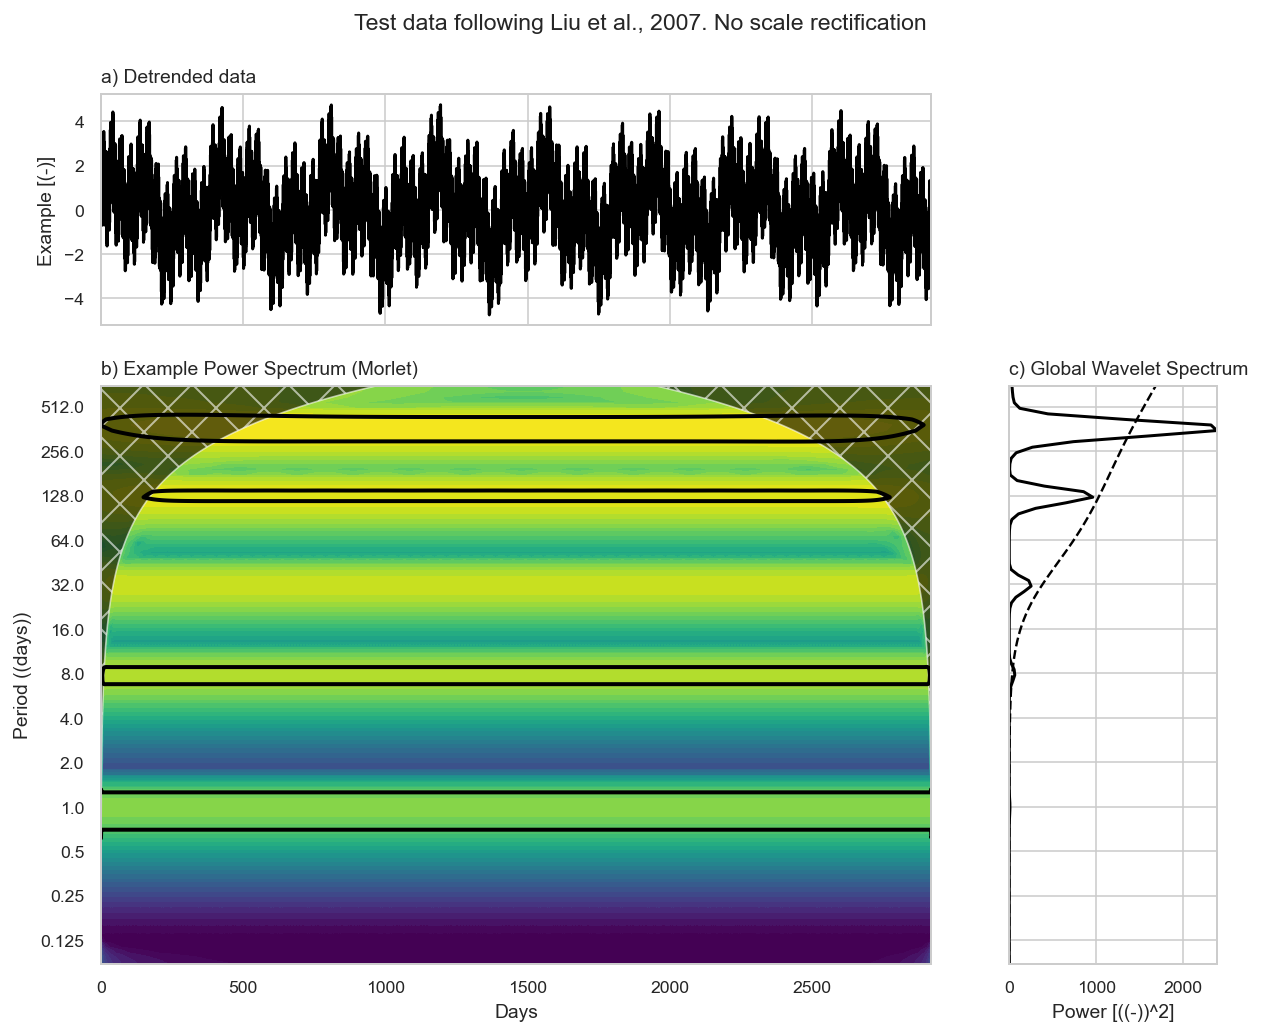

In [3]:
periods_days = np.array([1, 8, 32, 128, 365]) / 24
hours = np.arange(0, 8 * 365, 1 / 24)
signal = np.zeros_like(hours)
for p in periods_days:
    signal = signal + np.sin(hours * 2 * np.pi / (24 * p))

N = signal.size
mother = wavelet.Morlet()
# Twelve sub-octaves per octaves
# Nine powers of two with dj sub-octaves
octaves = [1 / 8, 13 / (1 / 8)]  

# Perform the CWT
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, 1/24, hours, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    rectify=False,
    norm_kwargs={'standardize': False, 'detrend': False}
)

# Create the periodogram
title = 'Test data following Liu et al., 2007. No scale rectification'
label = 'Example'
units = '(-)'
scale_units = '(days)'

fig_labels = {
    'title': title,
    'label': label,
    'units': units,
    'scale_units': scale_units,
    'mother': 'Morlet',
    'avg_scales': None,
    'xlabel': 'Days'
}

cwt_plt.plot_wv_power(
    signal_norm=signal_norm,
    x=hours,
    dx=1/24,
    period=period,
    power=power,
    coi=coi,
    glbl_signif=glbl_signif,
    glbl_power=glbl_power,
    sig95=sig95,
    scale_avg=scale_avg,
    scale_avg_signif=scale_avg_signif,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False
)

Here the problem is quite clear. Even though all of the oscillators have an identical amplitude, the largest scales have the largest spectra peaks.

### Now with rectification

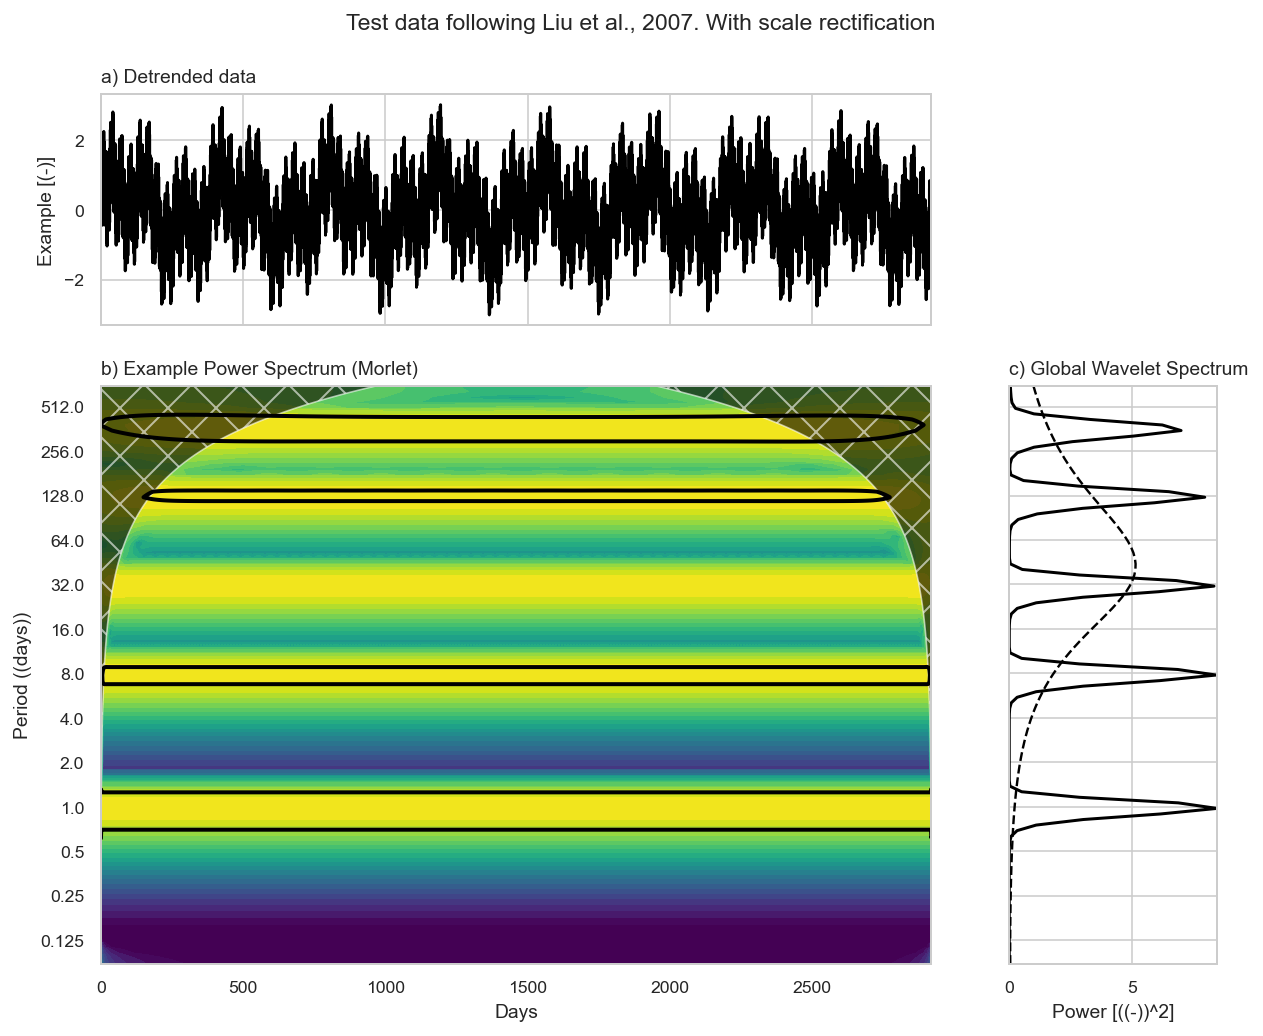

In [4]:
periods_days = np.array([1, 8, 32, 128, 365]) / 24
hours = np.arange(0, 8 * 365, 1 / 24)
signal = np.zeros_like(hours)
for p in periods_days:
    signal = signal + np.sin(hours * 2 * np.pi / (24 * p))

N = signal.size
mother = wavelet.Morlet()
# Twelve sub-octaves per octaves
# Nine powers of two with dj sub-octaves
octaves = [1 / 8, 13 / (1 / 8)]  

# Perform the CWT (note that rectify=True is the default)
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, 1/24, hours, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    rectify=True,
    norm_kwargs={'standardize': True, 'detrend': False},
)

# Create the periodogram
title = 'Test data following Liu et al., 2007. With scale rectification'
label = 'Example'
units = '(-)'
scale_units = '(days)'

fig_labels = {
    'title': title,
    'label': label,
    'units': units,
    'scale_units': scale_units,
    'mother': 'Morlet',
    'avg_scales': None,
    'xlabel': 'Days'
}

cwt_plt.plot_wv_power(
    signal_norm=signal_norm,
    x=hours,
    dx=1/24,
    period=period,
    power=power,
    coi=coi,
    glbl_signif=glbl_signif,
    glbl_power=glbl_power,
    sig95=sig95,
    scale_avg=scale_avg,
    scale_avg_signif=scale_avg_signif,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False
)

For reference, here is the equivalent plot from L07.

<img src='../figures/Liu2007_Fig2.png' width="600" height="600">

and here is a related plot that looks at just the global (time averaged) wavelet spectra:

<img src='../figures/Liu2007_Fig3.png' width="600" height="600">

I cannot convincingly resolve the difference in the global power between my tests and L07. However, I am skeptical that it is even possible as Figures 2 and 3 give inconsistent results (above).

Figure 2 gives peaks in the time-averaged rectified wavelet spectra of a bit greater than 5. I can approximately recreate that by turning off standardization and scaling the global power by the variance.

Figure 3 gives peaks for _the same quantity_ around ~40. I can approxiamtely recreate peaks of this size by turning on standardization and scaling the global power by the variance.

My suspicion is that everyone is using similar code to generating these kinds of periodograms. The code automatically adjusts the globally-averaged wavelet spectra to be in log2 space (compare Fig 2 and 3e). I suspect a similar process is at play in the below plots. I cannot exactly resolve these differences, however. While it is frustrating that I cannot resolve the small differences, I must move on.

### __pycwt, the rectification, and my helper functions behave as expected for the CWT.__